In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.text_cell_render.rendered_html{font size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input{font-family:Consolas; font-size:12pt;}
div.prompt {min width:70px;}
div#toc-wrapper {padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe {font-size:12px;}
</style>
"""))

In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns # iris 데이터 가져오기1
from sklearn import datasets # iris 데이터 가져오기2
from sklearn.preprocessing import LabelEncoder #원핫인코딩1
from tensorflow.keras.utils import to_categorical #원핫인코딩2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import metrics
import matplotlib.pyplot as plt

# 데이터셋 생성 및 전처리
- 데이터셋은 seaborn에서 가져오기
- X, y 분리 (scale 조정 X, 라벨인코딩+원핫인코딩)
- train, test 분리 (8:2)

In [8]:
# iris 데이터 가져오기
df = sns.load_dataset('iris')
df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [14]:
# X,y 데이터 분리
X_data = df.iloc[:,:-1].values
y_data = df.iloc[:,-1].values
X_data.shape, y_data.shape

((150, 4), (150,))

In [17]:
# y데이터 라벨인코딩
le = LabelEncoder()
encoded_y_data = le.fit_transform(y_data)
encoded_y_data

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [19]:
# 라벨인코딩 된 y 데이터 원핫인코딩
Y_data = to_categorical(encoded_y_data)
Y_data.shape

(150, 3)

In [21]:
# train과 test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, train_size=0.8, stratify=Y_data)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((120, 4), (120, 3), (30, 4), (30, 3))

# 모델구성 (입력4 -> 출력3, layer5: 4->64->128->50->30->3)
- 모델 학습과정 설정
- 모델 학습 (Earlystopping, ModelCheckPoint 추가)
- 모델평가 (시각화, 현재모델과 저장된 최고의 모델 평가, 교차표==혼동행렬)
- 모델예측/저장

In [25]:
# 모델 구성
model = Sequential()
model.add(Input(4))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=30, activation='relu'))
model.add(Dense(units=3, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 64)                320       
                                                                 
 dense_12 (Dense)            (None, 128)               8320      
                                                                 
 dense_13 (Dense)            (None, 50)                6450      
                                                                 
 dense_14 (Dense)            (None, 30)                1530      
                                                                 
 dense_15 (Dense)            (None, 3)                 93        
                                                                 
Total params: 16,713
Trainable params: 16,713
Non-trainable params: 0
_________________________________________________________________


In [27]:
# 학습시키기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#콜백함수 정의
earlyStopping = EarlyStopping(monitor='val_loss', patience=20)
import os
path = './model/iris/'
if not os.path.exists(path):
    os.mkdir(path)
filename = 'iris{epoch:03d}_loss_{val_loss:.4f}_acc{val_accuracy:.4f}.h5'
checkpoint = ModelCheckpoint(filepath=path+filename, monitor='val_accuracy', save_best_only=True, mode='max', verbose=0)

hist = model.fit(X_train, y_train, epochs=200, validation_split=0.1, callbacks=[earlyStopping, checkpoint], verbose=1)

Epoch 1/200
4/4 [==============================] - 1s 73ms/step - loss: 1.0884 - accuracy: 0.4352 - val_loss: 0.9812 - val_accuracy: 0.8333
Epoch 2/200
4/4 [==============================] - 0s 9ms/step - loss: 0.9738 - accuracy: 0.6481 - val_loss: 0.8965 - val_accuracy: 0.8333
Epoch 3/200
4/4 [==============================] - 0s 9ms/step - loss: 0.8850 - accuracy: 0.6481 - val_loss: 0.7767 - val_accuracy: 0.8333
Epoch 4/200
4/4 [==============================] - 0s 8ms/step - loss: 0.7996 - accuracy: 0.6481 - val_loss: 0.6409 - val_accuracy: 0.8333
Epoch 5/200
4/4 [==============================] - 0s 9ms/step - loss: 0.7210 - accuracy: 0.6481 - val_loss: 0.5398 - val_accuracy: 0.8333
Epoch 6/200
4/4 [==============================] - 0s 10ms/step - loss: 0.6451 - accuracy: 0.6481 - val_loss: 0.4611 - val_accuracy: 0.8333
Epoch 7/200
4/4 [==============================] - 0s 9ms/step - loss: 0.5852 - accuracy: 0.6481 - val_loss: 0.3888 - val_accuracy: 0.8333
Epoch 8/200
4/4 [========

4/4 [==============================] - 0s 10ms/step - loss: 0.1118 - accuracy: 0.9444 - val_loss: 0.0529 - val_accuracy: 1.0000
Epoch 60/200
4/4 [==============================] - 0s 9ms/step - loss: 0.0889 - accuracy: 0.9722 - val_loss: 0.0376 - val_accuracy: 1.0000
Epoch 61/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0923 - accuracy: 0.9630 - val_loss: 0.0737 - val_accuracy: 0.9167
Epoch 62/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0904 - accuracy: 0.9815 - val_loss: 0.0843 - val_accuracy: 0.9167
Epoch 63/200
4/4 [==============================] - 0s 9ms/step - loss: 0.1005 - accuracy: 0.9352 - val_loss: 0.0787 - val_accuracy: 0.9167
Epoch 64/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0948 - accuracy: 0.9722 - val_loss: 0.0443 - val_accuracy: 1.0000
Epoch 65/200
4/4 [==============================] - 0s 9ms/step - loss: 0.0888 - accuracy: 0.9722 - val_loss: 0.0984 - val_accuracy: 0.9167
Epoch 66/200
4/4 [===========

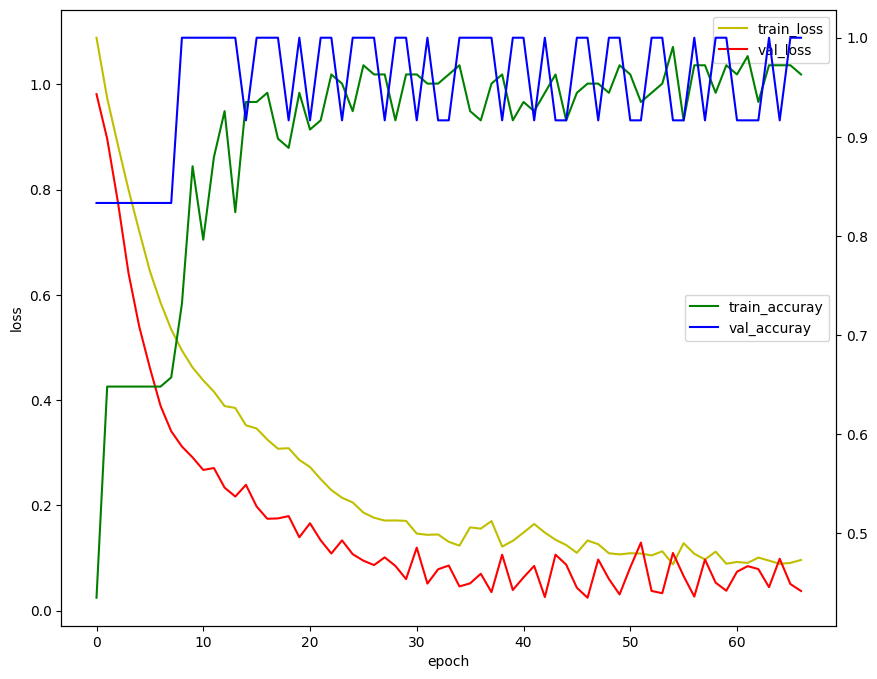

In [28]:
# 학습과정 표시하기
fig, loss_ax = plt.subplots(figsize=(10,8))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x 축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuray')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuray')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_xlabel('accuracy')
loss_ax.legend(loc='upper right')
acc_ax.legend(loc='center right')
plt.show()

In [29]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 23ms/step - loss: 0.0148 - accuracy: 1.0000


[0.014820513315498829, 1.0]

In [31]:
model1 = load_model(filepath=path+'iris009_loss_0.3116_acc1.0000.h5')
model1.evaluate(X_test, y_test)

1/1 [==============================] - 0s 106ms/step - loss: 0.4498 - accuracy: 0.8667


[0.4497855305671692, 0.8666666746139526]

In [32]:
# 더 좋은 모델 저장
save_model(model, filepath=path+'iris_model.h5')

In [60]:
#혼동행렬
y = le.inverse_transform(y_test.argmax(axis=1))
y_hat = le.inverse_transform(model.predict(X_test).argmax(axis=1))

pd.crosstab(y, y_hat, rownames=['real'], colnames=['predict'])


1/1 [==============================] - 0s 16ms/step


predict,setosa,versicolor,virginica
real,,,
setosa,10,0,0
versicolor,0,10,0
virginica,0,0,10


In [45]:
# 모델 사용하기
le.inverse_transform([model.predict(X_test[0].reshape(1,-1)).argmax()])

1/1 [==============================] - 0s 17ms/step


array(['virginica'], dtype=object)